## Data and import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL
# Ajouter export FRED_API_KEY="your_api_key" dans fichier .zshrc et .bashrc
# Sinon  ajouter (,api_key="my_api_key") dans .get_series de fonction fred_data
import pyfredapi as pf
import MacroRandomForest as MRF
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Use matplotlib's 'classic' style, set figure facecolor to white
plt.style.use('classic')
plt.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['figure.figsize'] = [20, 9]

global start_date, end_date, window_dates
start_date = np.datetime64('1980-01-01')
end_date = np.datetime64('2023-12-01')
current_date = start_date
window_dates = []

while current_date <= end_date:
    window_dates.append(current_date)
    current_date = np.datetime64(current_date, 'M') + np.timedelta64(1, 'M')

window_dates = np.array(window_dates, dtype='datetime64[M]').tolist()

gdpm = pd.read_excel("US-Monthly-GDP-History-Data.xlsx",sheet_name="Data")
gdpm.drop(columns=['Unnamed: 0'],inplace=True)
gdpm.set_index('Date',inplace=True)

- https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579
- https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
- https://en.wikipedia.org/wiki/Singular_spectrum_analysis
- https://stats.stackexchange.com/questions/158281/can-pca-be-applied-for-time-series-data

maths:
- https://online.stat.psu.edu/stat505/lesson/11/11.2

papier:
- https://www.sciencedirect.com/science/article/pii/S2212567116303045?ref=pdf_download&fr=RR-2&rr=83eb76473aced62a

- S&P/Case-Shiller U.S. National Home Price Index (CSUSHPINSA)
#### Rates
- Federal Funds Effective Rate (FEDFUNDS) *x*
- 30-Year Fixed Rate Mortgage Average in the United States (MORTGAGE30US) *x*
- 10-Year Real Interest Rate (REAINTRATREARAT10Y)
- Personal Saving Rate (PSAVERT)
- XXX / Personal Saving (PMSAVE)
- Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10)
#### Economics
- US Monthly GDP (MGDP) Index
> https://www.spglobal.com/marketintelligence/en/mi/products/us-monthly-gdp-index.html
- XXX / Gross Domestic Product (GDP)
- XXX / Real Gross Domestic Product (GDPC1)
- XXX / Leading Indicators OECD: Reference Series: Gross Domestic Product (GDP): Normalised for United States (USALORSGPNOSTSAM)
- XXX / Real Potential Gross Domestic Product (GDPPOT)
- Currency in Circulation (CURRCIR)
- M2 (M2SL)
- Industrial Production: Total Index (INDPRO)
- Unemployment Rate (UNRATE) *x*
- Labor Force Participation Rate (CIVPART)
- Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL) *x*
- XXX /Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average (CPILFESL)
- University of Michigan: Inflation Expectation (MICH)
- Real-time Sahm Rule Recession Indicator (SAHMREALTIME)
- XXX / GDP-Based Recession Indicator Index (JHGDPBRINDX)
- XXX / Deflation Probability (STLPPMDEF)
#### Household
- Personal Consumption Expenditures (PCE)
- XXX / Real Personal Consumption Expenditures (PCEC96)
- Real Disposable Personal Income (DSPIC96) *x*
- Household Estimates (TTLHHM156N)
- XXX / Population Level - 55 Yrs. & over (LNU00024230)
- XXX / Population Level (CNP16OV)
#### Banking
- Total Consumer Credit Owned and Securitized (TOTALSL)
- XXX / Consumer Loans: Credit Cards and Other Revolving Plans, All Commercial Banks (CCLACBW027SBOG)
- Deposits, All Commercial Banks (DPSACBW027SBOG)
#### Housing
- Monthly Supply of New Houses in the United States (MSACSR)
- XXX / New Privately-Owned Housing Units Started: Total Units (HOUST)

In [148]:
REQUEST_LIST = ["CSUSHPINSA","FEDFUNDS","DGS10","MORTGAGE30US","REAINTRATREARAT10Y","PSAVERT",
                  "CURRCIR","M2SL","INDPRO","UNRATE","CIVPART","CPIAUCSL","MICH",
                  "PCE","DSPIC96","TTLHHM156N","TOTALSL","DPSACBW027SBOG","MSACSR"]

def fred_data(L:list):
    x = pd.DataFrame(columns=L, index=window_dates)
    
    with tqdm(total=len(L), ascii=True) as pbar:
        for var in L:
            try:
                y = pf.get_series(series_id=var,observation_start=str(start_date),observation_end=str(end_date),frequency="m")
                y.set_index('date',inplace=True)
                y.drop(columns=["realtime_start","realtime_end"],inplace=True)
                x[var] = y.value
            except:
                None
            pbar.update()
    x['SPREAD'] = x['DGS10'] - x['FEDFUNDS']
    x = x.drop(columns=["FEDFUNDS","DGS10"])
    return x

#TODO: data request
data = fred_data(L=REQUEST_LIST)
data[['GDPn','GDPr']] = gdpm[['GDPn','GDPr']] # Monthly GDP data import
data = data.dropna()

display(data)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|##########| 19/19 [00:00<00:00, 497.06it/s]


,CSUSHPINSA,MORTGAGE30US,REAINTRATREARAT10Y,PSAVERT,CURRCIR,M2SL,INDPRO,UNRATE,CIVPART,CPIAUCSL,MICH,PCE,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,MSACSR,SPREAD,GDPn,GDPr
1992-01-01,75.700,8.43,3.198542,9.5,304.146,3381.2,61.4898,7.3,66.3,138.300,2.7,4084.7,7474.8,95776.0,798.98271,2473.1532,5.2,3.00,6315.725062,10177.847909
1992-02-01,75.655,8.76,3.628292,9.8,301.542,3400.0,61.9299,7.4,66.2,138.600,2.6,4099.5,7507.2,95888.0,799.64038,2484.7280,4.9,3.28,6356.503073,10222.868120
1992-03-01,75.814,8.94,3.660265,9.7,302.653,3403.9,62.4490,7.4,66.4,139.100,2.6,4117.0,7513.8,95984.0,799.44211,2495.0398,6.1,3.56,6417.077864,10307.994876
1992-04-01,76.080,8.85,3.789860,9.8,305.007,3399.7,62.9312,7.4,66.5,139.400,3.0,4131.5,7535.0,96309.0,797.65814,2495.1205,6.1,3.75,6443.259544,10314.363367
1992-05-01,76.398,8.67,3.746170,9.8,307.800,3398.6,63.1359,7.6,66.6,139.700,2.9,4158.4,7570.2,96456.0,797.66790,2484.9213,6.0,3.57,6433.810195,10293.428659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,305.365,6.43,1.536904,5.3,2333.155,20820.7,102.9240,3.7,62.6,303.294,4.2,18407.8,16818.5,130190.0,4958.80277,17274.7781,7.2,-1.49,27073.953429,22255.042049
2023-06-01,308.285,6.71,1.060631,4.8,2342.699,20854.5,102.3002,3.6,62.6,303.841,3.3,18485.4,16809.5,130179.0,4971.61099,17316.8828,7.5,-1.33,27191.380434,22314.750969
2023-07-01,310.146,6.84,1.426047,4.4,2340.641,20863.7,103.2166,3.5,62.6,304.348,3.4,18595.4,16808.4,130278.0,4984.85400,17343.2912,7.1,-1.22,27386.299100,22426.221180
2023-08-01,311.519,7.07,1.602095,4.4,2330.824,20825.5,103.2158,3.8,62.8,306.269,3.5,18651.6,16814.6,130287.0,4972.49265,17325.1125,7.9,-1.16,27624.369911,22505.479995


In [188]:
# --- Data Transformation
#TODO: usual transformation for stationarity 
#? "diff_ln" : 100*(log(x_'t') - log(x_'t-12')) = YoY growth rate
#? "diff" : 100*(x_'t' - x_'t-12') = YoY change in ... rate
#? rolling : special case of "MSACSR" : at time t it is the YoY% growth rate between : the number of houses added between (t) and (t)-11 (= over the past year) and the same number but between (t-12) and (t-12)-11 
#? "level" : no change on data

DATA_TRANSFORM = {
"diff_ln":[
"CSUSHPINSA",
"CURRCIR",
"M2SL",
"CPIAUCSL",
"INDPRO",
"PCE",
"DSPIC96",
"TTLHHM156N",
"TOTALSL",
"DPSACBW027SBOG",
"GDPr"
],

"diff":[
"MORTGAGE30US",
"REAINTRATREARAT10Y",
"UNRATE",
"CIVPART"
],

"level":[
"SPREAD",
"PSAVERT",
"MICH" 
],

"rolling":["MSACSR"]
}


def data_treat(df,treatment):
    
    def log_transform(cell_value):
        try:
            return np.log(float(cell_value))
        except (ValueError, TypeError):
            return cell_value
    
    x = pd.DataFrame(index=df.index)
    
    for key in treatment:
        if key=="diff_ln":
            x[treatment[key]] = 100*df[treatment[key]].applymap(log_transform).diff(periods=12)
        elif key=="diff":
            x[treatment[key]] = df[treatment[key]].diff(periods=12)
        elif key=="level":
            x[treatment[key]] = df[treatment[key]]
        else:
            x[treatment[key]] = 100*df[treatment[key]].rolling(12).sum().pct_change(periods=12)
    x = x.dropna()
    return x

df_data = data_treat(df=data,treatment=DATA_TRANSFORM)
VARIABLES_LIST = list(df_data.columns)[1::]
df_data

,CSUSHPINSA,CURRCIR,M2SL,CPIAUCSL,INDPRO,PCE,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,GDPr,MORTGAGE30US,REAINTRATREARAT10Y,UNRATE,CIVPART,SPREAD,PSAVERT,MICH,MSACSR
1993-12-01,2.133645,9.212538,1.443671,2.772180,3.350883,5.270937,1.407186,1.773860,7.125035,1.565067,2.723535,-1.04,-0.789569,-0.9,0.1,2.81,9.0,3.0,-5.546995
1994-01-01,2.332682,9.357181,1.618834,2.421426,3.267621,5.477629,1.715050,0.985836,7.461335,1.746216,2.868937,-0.93,-0.495224,-0.7,0.4,2.70,7.0,2.8,-5.069124
1994-02-01,2.429406,9.836077,1.776483,2.484600,2.851051,6.172477,1.427719,0.994390,7.829006,1.426838,3.278961,-0.53,-0.384616,-0.5,0.4,2.72,6.4,2.8,-6.106870
1994-03-01,2.542614,10.032467,1.985033,2.617229,3.946258,6.525624,2.063207,0.881876,9.118025,0.968924,3.969991,0.18,0.297778,-0.5,0.3,3.14,6.7,3.0,-6.018519
1994-04-01,2.627580,10.049516,2.031234,2.336876,4.237189,6.129118,1.543746,1.024158,9.448576,0.392099,3.913022,0.85,0.884666,-0.7,0.4,3.41,6.3,3.0,-3.154574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,-0.361861,2.652660,-3.977345,4.045883,0.143023,5.717823,4.844180,1.675374,5.540991,-4.756079,2.425365,1.20,0.333006,0.1,0.3,-1.49,5.3,4.2,34.271100
2023-06-01,0.006163,2.803391,-3.817907,3.045164,-0.376708,5.192728,5.164560,1.601335,5.088911,-4.256655,2.653249,1.19,0.035538,0.0,0.4,-1.33,4.8,3.3,25.763126
2023-07-01,0.985670,2.672625,-3.946734,3.245824,0.081221,5.749568,4.248202,1.656282,4.791489,-4.048647,3.265240,1.43,0.363872,0.0,0.5,-1.22,4.4,3.4,15.874855
2023-08-01,2.555826,2.416576,-3.927519,3.640429,-0.018019,5.280807,3.962187,1.679580,3.964809,-4.065942,2.355520,1.85,0.746470,0.2,0.4,-1.16,4.4,3.5,12.090395


In [189]:
# ---------------------------------- #
#--- Factor MA (MAF) --------------- #
# ---------------------------------- #
#? Expliqué dans l'article: 
#? au lieu d'utiliser x(t), x(t-1), x(t-3) ... x(t-p) comme variables dans le dataset on utilise juste la sortie de factorMA(p=p) 
#? qui résume l'info contenue dans x(t), x(t-1), x(t-3) ... x(t-p) en (ici) 3 principal components 

def factorMA(ts,p=12):
    x = ts.copy()
    
    name = ts.columns[0]
    for i in range(1,p+1):
        x[f"{name}_{i}"] = ts.shift(i)[name]
    x = x.dropna()
    std_x = x - x.mean(axis = 0)
    covariance_matrix = np.cov(std_x, ddof = 1, rowvar = False)
    res = pd.DataFrame(index=x.index)
    
    #* >PCA
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    order_of_importance = np.argsort(eigenvalues)[::-1] 
    # utilize the sort order to sort eigenvalues and eigenvectors
    sorted_eigenvalues = eigenvalues[order_of_importance]
    sorted_eigenvectors = eigenvectors[:,order_of_importance]
    # 3 MAFs
    for i in range(0,3):
        res[f'{name}_PCA{i}'] = pd.DataFrame(np.asarray(std_x) @ np.asarray(sorted_eigenvectors[i]),index=x.index).values
    return res

# ---------------------------------- #

def usual_PCA(df):
    x = df.copy()
    res = pd.DataFrame(index=df.index)
    std_x = x - x.mean(axis = 0)
    covariance_matrix = np.cov(std_x, ddof = 1, rowvar = False)
    #* >PCA
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    order_of_importance = np.argsort(eigenvalues)[::-1] 
    sorted_eigenvalues = eigenvalues[order_of_importance]
    sorted_eigenvectors = eigenvectors[:,order_of_importance]
    for i in range(0,5):
        res[f'PCA{i}'] = pd.DataFrame(np.asarray(std_x) @ sorted_eigenvectors[:,i],index=x.index)[0]
    return res


In [190]:
# ---------------------------------- #

#* > MAF (PCA on p=12 lags for each variable, retrieve first 3 components)
"""
for k in range(1,len(VARIABLES_LIST)):
    maf = factorMA(ts=df_data[[VARIABLES_LIST[k]]])
    df_data[list(maf.columns)] = maf 
"""

#* Step ahead forecast
for k in [1,3,6]:
    df_data[f"CSUSHPINSA+{k}"] = df_data["CSUSHPINSA"].shift(periods=-k)

#* > lags [1:3] of all variables
for k in range(1,len(VARIABLES_LIST)):
    for i in range(1,4):
        df_data[f"{VARIABLES_LIST[k]}-{i}"] = df_data[f"{VARIABLES_LIST[k]}"].shift(periods=i)

#* > Lags of dependent variable : up to ...
for k in range(1,7):
    df_data[f"CSUSHPINSA-{k}"] = df_data["CSUSHPINSA"].shift(periods=k)
    
df_data = df_data.dropna()
df_data

,CSUSHPINSA,CURRCIR,M2SL,CPIAUCSL,INDPRO,PCE,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,...,MICH-3,MSACSR-1,MSACSR-2,MSACSR-3,CSUSHPINSA-1,CSUSHPINSA-2,CSUSHPINSA-3,CSUSHPINSA-4,CSUSHPINSA-5,CSUSHPINSA-6
1994-06-01,2.779777,9.964915,1.071970,2.464190,5.535966,5.879996,2.864090,1.058957,11.500371,-0.293920,...,3.0,-2.073365,-3.154574,-6.018519,2.788235,2.627580,2.542614,2.429406,2.332682,2.133645
1994-07-01,2.758044,10.134749,1.333315,2.663182,5.403425,5.479362,2.701568,0.820550,11.555830,0.124052,...,3.0,0.160514,-2.073365,-3.154574,2.779777,2.788235,2.627580,2.542614,2.429406,2.332682
1994-08-01,2.759440,9.897389,1.154181,2.859283,6.178741,6.092519,2.676250,0.763854,12.446085,0.185964,...,3.1,1.765650,0.160514,-2.073365,2.758044,2.779777,2.788235,2.627580,2.542614,2.429406
1994-09-01,2.702356,9.746023,0.977192,2.922396,5.956955,5.676428,3.385383,0.968264,13.007632,-0.146626,...,2.7,2.236422,1.765650,0.160514,2.759440,2.758044,2.779777,2.788235,2.627580,2.542614
1994-10-01,2.690791,9.566509,0.795279,2.576414,6.036615,5.995996,4.818656,0.970175,13.328773,0.458203,...,2.9,4.160000,2.236422,1.765650,2.702356,2.759440,2.758044,2.779777,2.788235,2.627580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,7.288118,3.575664,0.390963,6.892278,1.834506,6.648499,-1.651152,1.545816,7.474887,-0.351462,...,4.8,52.160000,56.271186,56.914894,8.755112,10.158814,12.193446,14.548122,16.572259,18.204098
2022-12-01,5.508849,3.278711,-0.890291,6.245767,0.591787,6.590224,-0.938704,1.604477,7.321320,-0.817413,...,4.7,52.713178,52.160000,56.271186,7.288118,8.755112,10.158814,12.193446,14.548122,16.572259
2023-01-01,3.768648,2.952760,-1.592218,6.153862,1.498379,7.640781,3.189113,1.345614,7.364201,-1.468031,...,5.0,53.636364,52.713178,52.160000,5.508849,7.288118,8.755112,10.158814,12.193446,14.548122
2023-02-01,2.139375,2.914879,-2.207235,5.814095,0.872003,7.351409,3.441076,1.335775,6.901669,-1.965042,...,5.0,52.949853,53.636364,52.713178,3.768648,5.508849,7.288118,8.755112,10.158814,12.193446


## MRF : as an explicative tool

In [268]:
# ---------------------------------- #
###* Dependent Variable
#Y_VAR = "CSUSHPINSA+1"  # One-step ahead
Y_VAR = "CSUSHPINSA+3"  # One-step ahead
#Y_VAR = "CSUSHPINSA+6"  # One-step ahead

###* Linear part
#X_VAR = ["CSUSHPINSA","CSUSHPINSA-1","CSUSHPINSA-2","CPIAUCSL","DSPIC96","GDPr","SPREAD","MORTGAGE30US","UNRATE"]    #* AR(3) and 1 lag of each
#X_VAR = ["CSUSHPINSA","CSUSHPINSA-1","CSUSHPINSA-2"]                                                                 #* AR(3)
#X_VAR = ["CSUSHPINSA","CPIAUCSL","DSPIC96","GDPr","SPREAD","MORTGAGE30US","UNRATE"]                                  #* Regressors
X_VAR = ["CSUSHPINSA","CPIAUCSL","DSPIC96","SPREAD","MORTGAGE30US","UNRATE"]                                          #* Regressors


###* Exogenous Variables
#S_VAR = [f"CSUSHPINSA-{i}" for i in range(1,13)] + [cols for cols in df_data.columns if "PCA" in cols]
#S_VAR = list(df_data.columns)[1::]
S_VAR = [var for var in df_data.columns if "+" not in var]
# ---------------------------------- #

# ================================== #
# ================================== #
data_MRF = pd.DataFrame(index = df_data.index)
data_MRF[[Y_VAR]] = df_data[[Y_VAR]].copy()
data_MRF[X_VAR] = df_data[X_VAR].copy()
data_MRF[S_VAR] = df_data[S_VAR].copy()
data_MRF.T.drop_duplicates().T          #drop duplicate columns if any
# ================================== #
# ================================== #

# ---------------------------------- #
Y_pos = data_MRF.columns.get_loc(Y_VAR)
S_pos = [data_MRF.columns.get_loc(s) for s in S_VAR]
X_pos = [data_MRF.columns.get_loc(x) for x in X_VAR]
# ---------------------------------- #

# ======= OOS-WINDOWS ============== #
K_OOS = 48
oos_pos = np.arange(len(data_MRF) - K_OOS, len(data_MRF))

In [269]:
data_MRF

,CSUSHPINSA+3,CSUSHPINSA,CPIAUCSL,DSPIC96,SPREAD,MORTGAGE30US,UNRATE,CURRCIR,M2SL,INDPRO,...,MICH-3,MSACSR-1,MSACSR-2,MSACSR-3,CSUSHPINSA-1,CSUSHPINSA-2,CSUSHPINSA-3,CSUSHPINSA-4,CSUSHPINSA-5,CSUSHPINSA-6
1994-06-01,2.702356,2.779777,2.464190,2.864090,2.85,0.98,-0.9,9.964915,1.071970,5.535966,...,3.0,-2.073365,-3.154574,-6.018519,2.788235,2.627580,2.542614,2.429406,2.332682,2.133645
1994-07-01,2.690791,2.758044,2.663182,2.701568,3.04,1.40,-0.8,10.134749,1.333315,5.403425,...,3.0,0.160514,-2.073365,-3.154574,2.779777,2.788235,2.627580,2.542614,2.429406,2.332682
1994-08-01,2.526344,2.759440,2.859283,2.676250,2.77,1.40,-0.8,9.897389,1.154181,6.178741,...,3.1,1.765650,0.160514,-2.073365,2.758044,2.779777,2.788235,2.627580,2.542614,2.429406
1994-09-01,2.485715,2.702356,2.922396,3.385383,2.73,1.72,-0.8,9.746023,0.977192,5.956955,...,2.7,2.236422,1.765650,0.160514,2.759440,2.758044,2.779777,2.788235,2.627580,2.542614
1994-10-01,2.312001,2.690791,2.576414,4.818656,2.98,2.10,-1.0,9.566509,0.795279,6.036615,...,2.9,4.160000,2.236422,1.765650,2.702356,2.759440,2.758044,2.779777,2.788235,2.627580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,2.139375,7.288118,6.892278,-1.651152,0.11,3.74,-0.5,3.575664,0.390963,1.834506,...,4.8,52.160000,56.271186,56.914894,8.755112,10.158814,12.193446,14.548122,16.572259,18.204098
2022-12-01,0.765423,5.508849,6.245767,-0.938704,-0.48,3.26,-0.4,3.278711,-0.890291,0.591787,...,4.7,52.713178,52.160000,56.271186,7.288118,8.755112,10.158814,12.193446,14.548122,16.572259
2023-01-01,-0.067973,3.768648,6.153862,3.189113,-0.80,2.82,-0.6,2.952760,-1.592218,1.498379,...,5.0,53.636364,52.713178,52.160000,5.508849,7.288118,8.755112,10.158814,12.193446,14.548122
2023-02-01,-0.361861,2.139375,5.814095,3.441076,-0.82,2.50,-0.2,2.914879,-2.207235,0.872003,...,5.0,52.949853,53.636364,52.713178,3.768648,5.508849,7.288118,8.755112,10.158814,12.193446


In [270]:
# ================================== #
#TODO: /// MRF FIT ///
MRF_model = MRF.MacroRandomForest(data = data_MRF,
            y_pos = Y_pos,
            x_pos = X_pos,
            S_pos = S_pos,
            mtry_frac=0.15,
            B = 1000,
            parallelise = True,
            n_cores = -1,
            resampling_opt = 2,
            oos_pos = oos_pos,
            trend_push = 4,
            quantile_rate=None,
            ridge_lambda=0.01,
            subsampling_rate=0.5,
            rw_regul=0.75,
            print_b = True,
            fast_rw = True)

# ================================== #
#TODO: /// MRF training ///
MRF_output = MRF_model._ensemble_loop()

Tree 6 out of 1000
Tree 5 out of 1000
Tree 1 out of 1000Tree 4 out of 1000

Tree 3 out of 1000
Tree 2 out of 1000
Tree 7 out of 1000
Tree 8 out of 1000
Tree 9 out of 1000
Tree 10 out of 1000
Tree 11 out of 1000
Tree 12 out of 1000
Tree 13 out of 1000
Tree 15 out of 1000
Tree 14 out of 1000
Tree 16 out of 1000
Tree 17 out of 1000
Tree 18 out of 1000
Tree 19 out of 1000
Tree 20 out of 1000
Tree 21 out of 1000
Tree 22 out of 1000
Tree 23 out of 1000
Tree 24 out of 1000
Tree 25 out of 1000
Tree 26 out of 1000
Tree 27 out of 1000
Tree 28 out of 1000
Tree 29 out of 1000
Tree 30 out of 1000
Tree 31 out of 1000
Tree 32 out of 1000
Tree 33 out of 1000
Tree 34 out of 1000
Tree 35 out of 1000
Tree 36 out of 1000
Tree 37 out of 1000
Tree 38 out of 1000
Tree 39 out of 1000
Tree 40 out of 1000
Tree 41 out of 1000
Tree 42 out of 1000
Tree 43 out of 1000
Tree 44 out of 1000
Tree 45 out of 1000
Tree 46 out of 1000
Tree 47 out of 1000
Tree 48 out of 1000
Tree 49 out of 1000
Tree 50 out of 1000
Tree 51 o

In [271]:
mean_squared_error(df_data.iloc[oos_pos][Y_VAR].values, MRF_output["pred"].values)

5.560218262876721

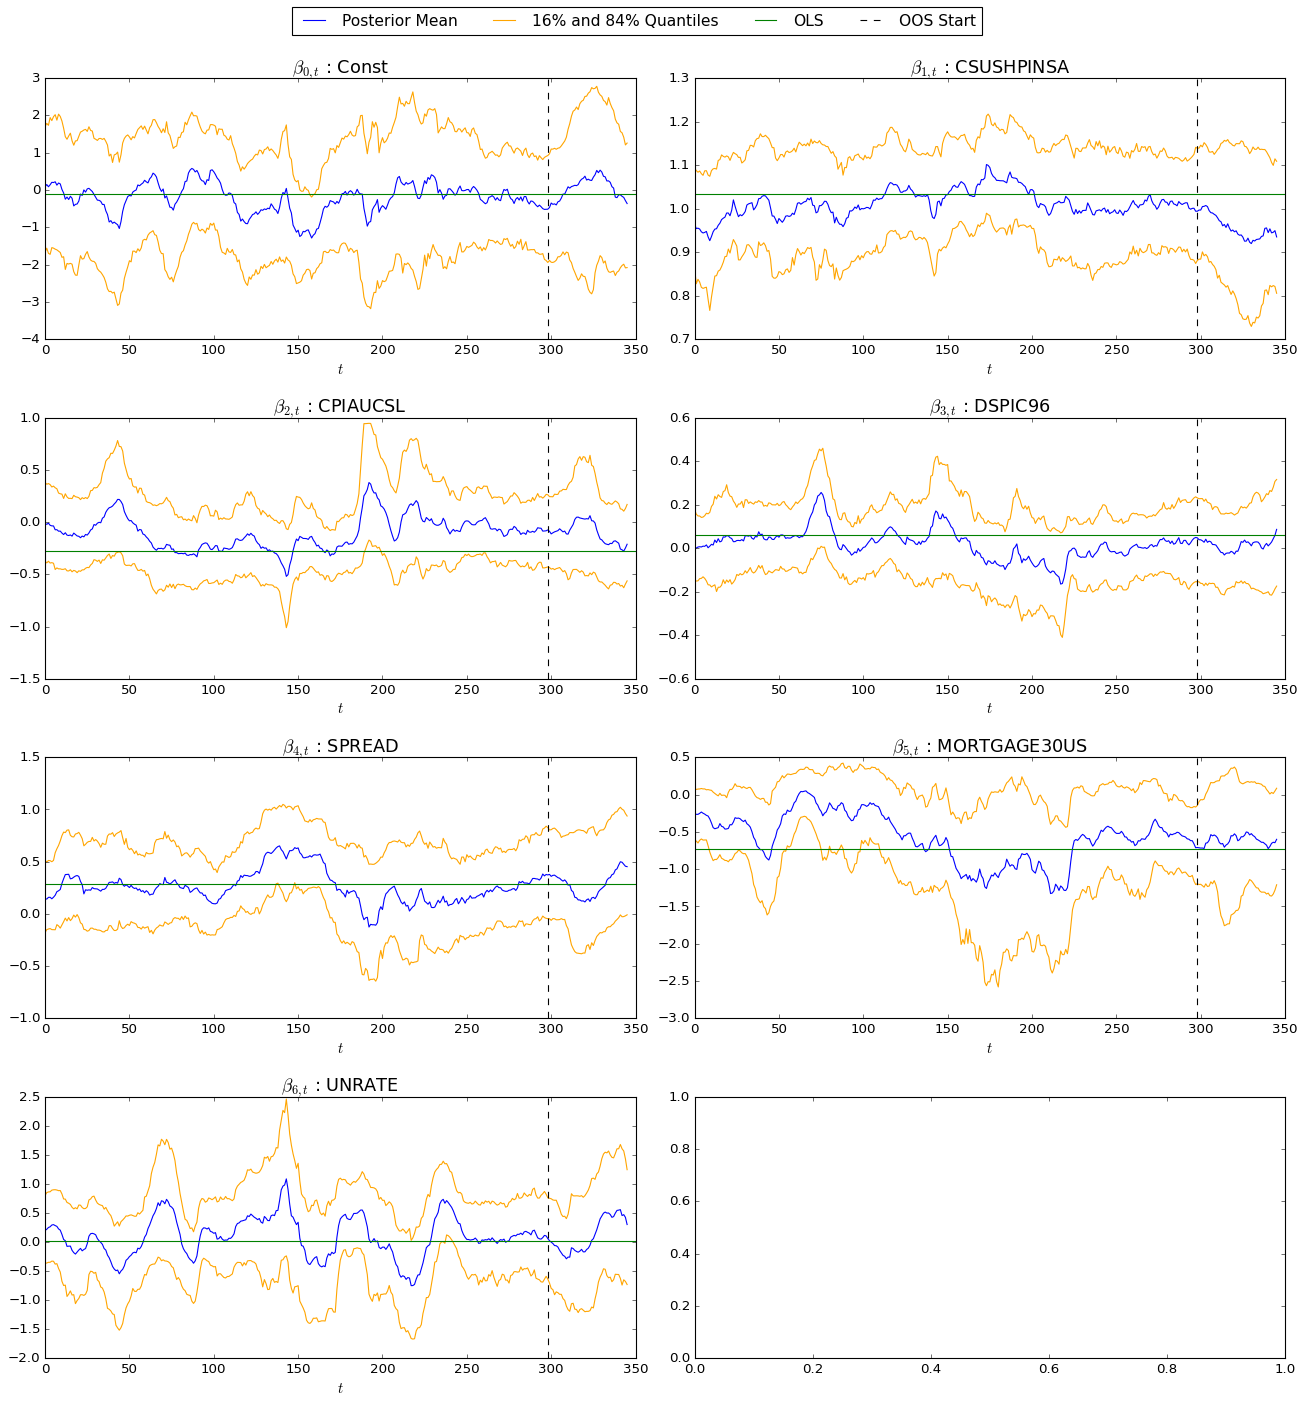

In [272]:
MRF_model.band_plots()

In [273]:
beta_res = pd.DataFrame(MRF_output['betas'],index=df_data.index,columns=['const']+X_VAR)
beta_res

,const,CSUSHPINSA,CPIAUCSL,DSPIC96,SPREAD,MORTGAGE30US,UNRATE
1994-06-01,0.085835,0.964416,-0.014334,0.001248,0.146328,-0.271684,0.196730
1994-07-01,0.145558,0.954097,-0.021443,0.000846,0.141777,-0.265045,0.217884
1994-08-01,0.085556,0.955102,-0.010377,0.005455,0.158535,-0.265855,0.247900
1994-09-01,0.139267,0.953106,-0.030783,0.006756,0.159056,-0.252566,0.260775
1994-10-01,0.205015,0.946769,-0.036274,0.005689,0.144769,-0.234808,0.290719
...,...,...,...,...,...,...,...
2022-11-01,-0.129519,0.953539,-0.257470,0.018872,0.499001,-0.696327,0.555628
2022-12-01,-0.170194,0.944307,-0.265344,0.028312,0.494573,-0.654186,0.453625
2023-01-01,-0.199650,0.945643,-0.277750,0.043576,0.475914,-0.639884,0.469426
2023-02-01,-0.286396,0.949405,-0.248114,0.058980,0.456257,-0.645705,0.423074


In [274]:
fit_res = pd.DataFrame(index=beta_res.index)
for x in X_VAR:
    fit_res[x] = beta_res[x]*df_data[x]
fit_res['const'] = beta_res['const']

fit_res['training'] = fit_res.sum(axis=1)
fit_res['oos'] = fit_res['training']
fit_res['training'].iloc[oos_pos] = np.nan
fit_res['oos'].iloc[:len(fit_res)-len(oos_pos)] = np.nan
fit_res['actual'] = df_data[Y_VAR]
fit_res

#for x in X_VAR:
#    fit_res[[x]].plot()

,CSUSHPINSA,CPIAUCSL,DSPIC96,SPREAD,MORTGAGE30US,UNRATE,const,training,oos,actual
1994-06-01,2.680861,-0.035321,0.003573,0.417034,-0.266250,-0.177057,0.085835,2.708675,NaN,2.702356
1994-07-01,2.631443,-0.057107,0.002286,0.431003,-0.371063,-0.174307,0.145558,2.607813,NaN,2.690791
1994-08-01,2.635546,-0.029671,0.014599,0.439141,-0.372197,-0.198320,0.085556,2.574654,NaN,2.526344
1994-09-01,2.575632,-0.089961,0.022872,0.434222,-0.434414,-0.208620,0.139267,2.438997,NaN,2.485715
1994-10-01,2.547557,-0.093457,0.027413,0.431411,-0.493098,-0.290719,0.205015,2.334121,NaN,2.312001
...,...,...,...,...,...,...,...,...,...,...
2022-11-01,6.949503,-1.774554,-0.031161,0.054890,-2.604263,-0.277814,-0.129519,NaN,2.187083,2.139375
2022-12-01,5.202042,-1.657275,-0.026577,-0.237395,-2.132645,-0.181450,-0.170194,NaN,0.796506,0.765423
2023-01-01,3.563794,-1.709236,0.138968,-0.380731,-1.804472,-0.281656,-0.199650,NaN,-0.672983,-0.067973
2023-02-01,2.031133,-1.442557,0.202954,-0.374131,-1.614263,-0.084615,-0.286396,NaN,-1.567875,-0.361861


<Axes: >

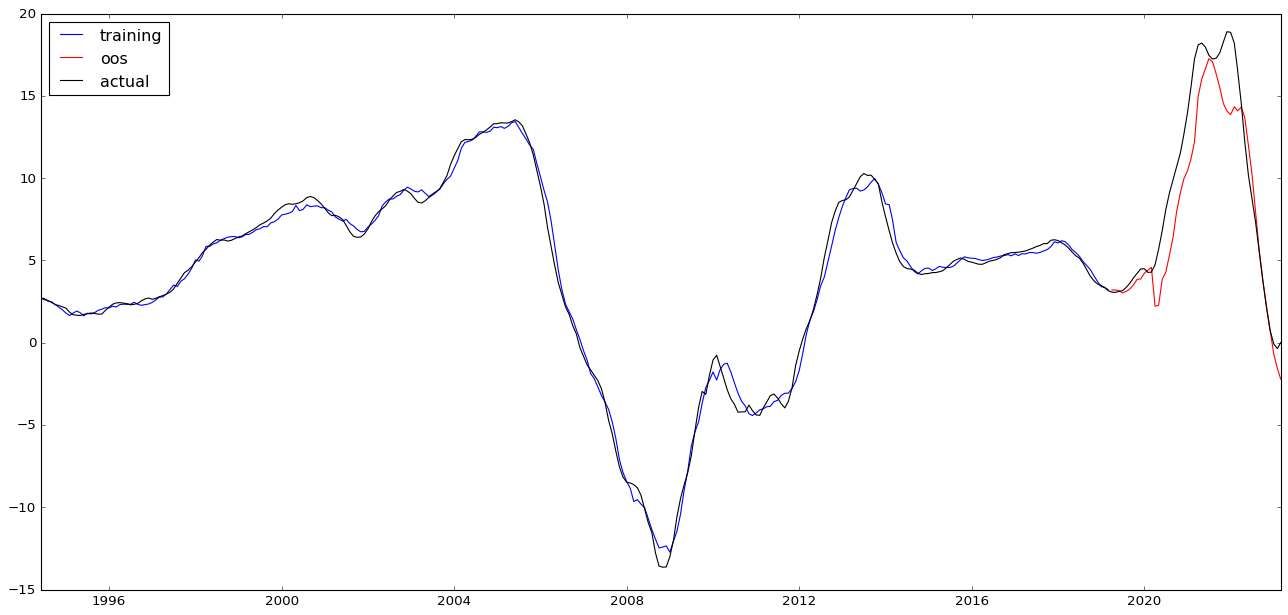

In [275]:
fit_res[['training','oos','actual']].plot(color=['blue','red','black'])

In [276]:
r2_score(fit_res.iloc[oos_pos]["actual"].values, fit_res.iloc[oos_pos]["oos"].values)

0.8614105228066973

run1

In [ ]:
cv_datasets = {}
tscv = TimeSeriesSplit()
for i, (train_index, test_index) in enumerate(tscv.split(data_MRF.iloc[:len(data_MRF)-K_OOS])):
     print(f"Fold {i}:")
     print(f"  Train: index={type(train_index)}")
     print(f"  Test:  index={test_index}")
     #cv_datasets[i] = {"train":train_index,"test":test_index}

In [ ]:
"""
def MRF_CV(data,Y_pos, X_pos, S_pos, K_OOS=12, lambdas=[0.001,0.0025,0.005]):
    
    MSE_cv = {l:None for l in lambdas}
    train_df = data.iloc[:len(data)-K_OOS].copy()
    STORE_RESULTS ={}
    
    with tqdm(total=len(lambdas), ascii=True) as pbar:
        for l in lambdas:
            print(f"CV : lambda = {l}")    
            
            # CROSS VALIDATION
            tscv = TimeSeriesSplit()
            mse = 0
            for i, (train_index, test_index) in enumerate(tscv.split(train_df)):    
                
                print(f'Fold {i+1}')
                fold_data = train_df.iloc[list(train_index)+list(test_index)].copy()
                MRF_model = MRF.MacroRandomForest(data = fold_data,
                    y_pos = Y_pos, 
                    x_pos = X_pos,
                    S_pos = S_pos,
                    oos_pos = test_index,
                    ridge_lambda=l,
                    mtry_frac=0.15,
                    B = 1000,
                    parallelise = True,
                    n_cores = -1,
                    resampling_opt = 2,
                    trend_push = 4,
                    quantile_rate=None,
                    subsampling_rate=0.75,
                    rw_regul=0.75,
                    print_b = False,
                    fast_rw = True)
                MRF_output = MRF_model._ensemble_loop()
                mse += mean_squared_error(fold_data.iloc[test_index][Y_pos].values, MRF_output["pred"].values)      # Predicted variable is House prices "CSUSHPINSA"
                
                
            MSE_cv[l] = mse/tscv.get_n_splits()
            pbar.update()
            print("\n")
                
    return MSE_cv

MRF_CV(data=data_MRF, Y_pos=Y_pos, X_pos=X_pos, S_pos=S_pos)
"""